In [1]:
from stable_baselines3 import DQN, PPO
from utils import *
from data_logger import DataLogger
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
#Loading parameters
ep, lp, hp = get_params("mario") #params["environment"], params["logging"], params["hyperparameters"]
hp_algo = hp['dqn/ddqn']

In [3]:
#Environment
env = get_env(game=ep["game"], level=ep["level"], action_space=ep["action_space"])
env = apply_wrappers(env, skip=ep["skip"], gray_scale=ep["gray_scale"], shape=ep["frame_shape"], num_stack=ep["num_stack"])
next_state = env.reset()
print(next_state.shape)

(4, 84, 84)


{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 93}


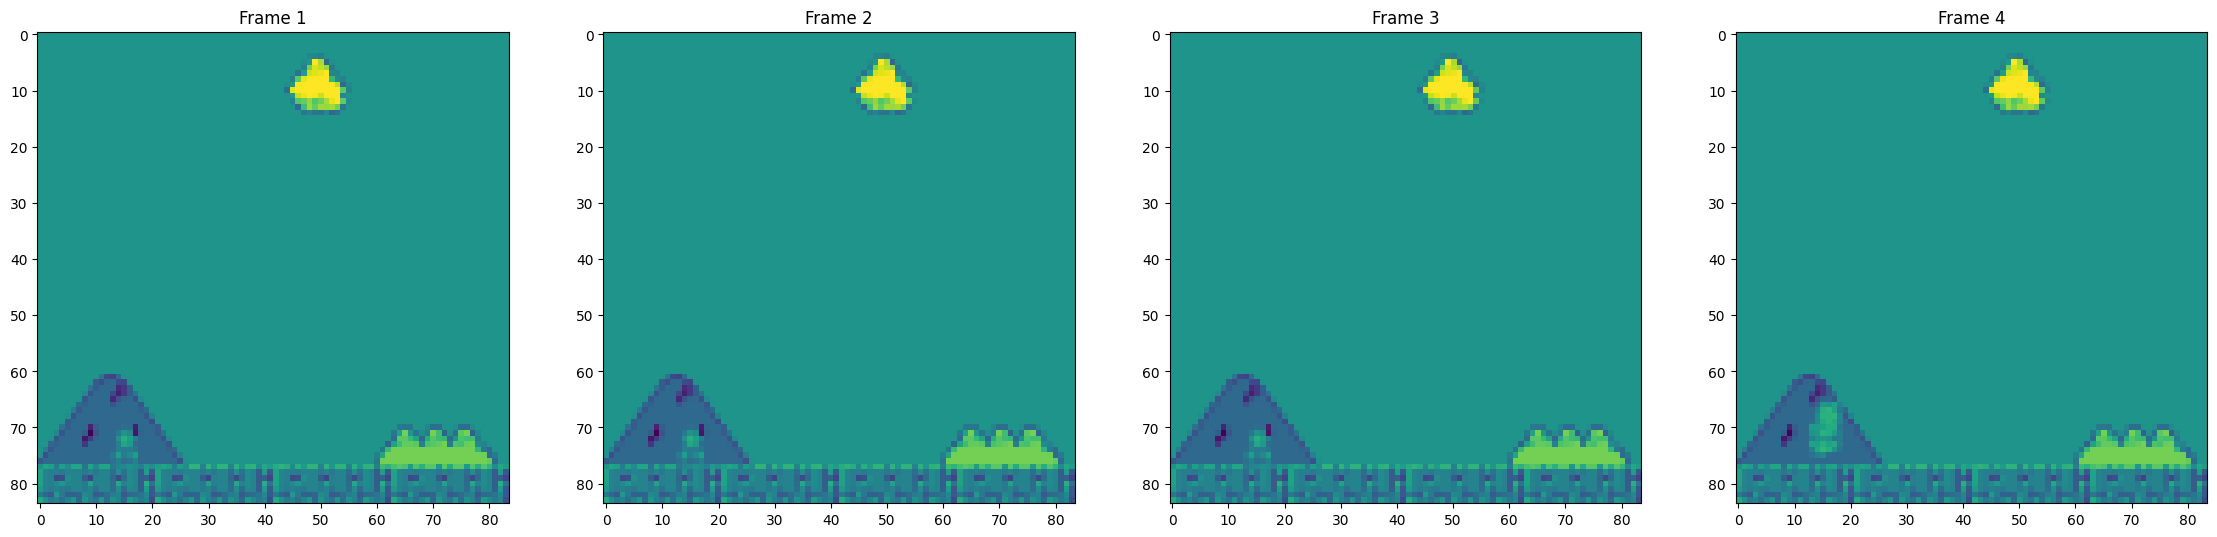

In [4]:
from utils import *
next_state, reward, done, info = env.step(get_action_sample(env))
plot_sequence_observations(next_state)
print(info)

In [ ]:
#Logging
from stable_baselines3.common.callbacks import BaseCallback
import collections

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting winrate in tensorboard and saving hyperparameters.
    """
    def __init__(self, verbose=0, game="mario"):
        super().__init__(verbose)
        self.reward_history = []
        self.win_rate_history = []
        self.episodes_prev_act = collections.deque([0, 0], maxlen=2)
        self.win_prev_act = collections.deque([0, 0], maxlen=2)
        self.game = game
        self.episode_num = 0

    def _on_step(self) -> bool:
        self.episodes_prev_act.append(self.episode_num)

        if self.game=="mario":
            if self.locals["dones"][0] or self.locals["infos"][0]["flag_get"]:
                self.episode_num += 1
            self.win_prev_act.append(int(self.locals["infos"][0]["flag_get"]))
        elif self.game=="sonic":
            if self.locals["dones"][0]:
                self.episode_num += 1
            self.win_prev_act.append(int(self.locals["dones"][0] and (self.locals["infos"][0]["prev_progress"])))
        
        if self.episodes_prev_act[0] != self.episodes_prev_act[1]:
            self.logger.record("rollout/winrate", self.win_prev_act[0])
            self.win_rate_history.append(self.win_prev_act[0])        
            self.reward_history.append(self.model.ep_info_buffer[-1]["r"])        
        return True   

logger = DataLogger(env, hp, model=hp_algo["model"])
checkpoint_callback = CheckpointCallback(save_freq=lp["n_time_steps_save_model"], save_path=logger.folder_path_models, name_prefix="chkpt")#saving the model periodically
eval_callback = EvalCallback(env, best_model_save_path=logger.folder_path_models, log_path=logger.folder_path_models, eval_freq=lp["evaluate_best_model_every"], deterministic=True, render=False)#evaluating the model periodically and saving the best one
log_callback = TensorboardCallback(game = ep["game"])

In [ ]:
#Hyperparams DQN
model = DQN("CnnPolicy",
            env,
            double_dqn = (hp_algo["model"]=="DDQN"), 
            buffer_size = hp_algo["buffer_size"],
            batch_size = hp_algo["batch_size"],
            learning_starts = hp_algo["learning_starts"],
            learning_rate = hp_algo["learning_rate"],
            gamma = hp_algo["discount_factor"],  
            exploration_fraction = hp_algo["exploration_fraction"],
            exploration_final_eps = hp_algo["exploration_final_eps"],
            train_freq = hp_algo["train_freq"],                    
            target_update_interval = hp_algo["target_update_interval"],   
            tensorboard_log = logger.folder_path_train,
            verbose = 1,
            device = device
            )

In [ ]:
#model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=logger.folder_path_train, learning_rate=hp_algo["learning_rate"])

In [ ]:
model.learn(hp_algo["time_steps"],
            callback=[log_callback, checkpoint_callback, eval_callback],
            tb_log_name="testing")

logger.total_rewards = log_callback.reward_history
logger.wins = log_callback.win_rate_history
logger.close()

In [ ]:
#Restart training
model_path = r"logs\SuperMarioBros-1-1-v0\PPO\20240205004950\checkpoints\chkpt_2000000_steps.zip"
log_path = r"logs\SuperMarioBros-1-1-v0\PPO\20240205004950\train"
model = PPO.load(model_path, tensorboard_log=log_path)
model.set_env(env)

In [ ]:
model.learn(hp_algo["time_steps"],
            callback=[log_callback, checkpoint_callback, eval_callback],
            reset_num_timesteps=False)